# Testing a simple workflow

- Import dataset, do some clean up, fix scitypes
- Unpack predictors and response variable
- Load a ridge regressor model
- Create a pipeline with the following steps:
    - Standardize all continuous predictors
    - One hot encode all multiclass predictors
    - Transform target using log
    - Inverse target using exp

In [1]:
using MLJ, MLJBase, CSV, DataFrames, CairoMakie

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame; missingstring="NA") |>
dropmissing |>
x -> DataFrames.select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "SX", "SNR") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "sx", "snr"]) |>
x -> coerce(x, Count => Continuous, Textual => Multiclass)

,biomass,basalarea,pl,lon,lat,sx,snr
,Float64,Float64,Float64,Float64,Float64,Float64,Cat…
1,3.3,5.52,0.0,-124.205,55.2704,0.0,B
2,1.97,10.44,0.0,-124.202,55.2649,60.0,C
3,1158.52,16.42,100.0,-124.633,55.4289,0.0,C
4,3474.61,7.77,100.0,-124.622,55.4232,0.0,C
5,1.72,22.54,0.0,-124.625,55.4193,60.0,C
6,3462.56,15.24,100.0,-124.64,55.4299,0.0,C
7,1.93,30.54,0.0,-124.33,55.3043,0.0,C
8,3.53,16.0,0.0,-124.323,55.3038,0.0,C
9,1.56,36.82,0.0,-124.323,55.3021,80.0,C


In [3]:
# Unpack predictors and response variable
y, X = unpack(lichen_training, ==(:biomass), _->true);

In [4]:
# Ridge Regressor Model
model = @load RidgeRegressor pkg=MLJLinearModels verbosity=0
pipe = @pipeline Standardizer OneHotEncoder model target=x -> log.(x) inverse=x -> exp.(x)
mach = machine(pipe, X, y)
fit!(mach);

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372
┌ Info: Training Machine{Pipeline281,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{WrappedFunction,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{WrappedFunction,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{OneHotEncoder,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Spawning 3 sub-features to one-hot encode feature :snr.
└ @ MLJModels C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\builtins\Transf

In [5]:
# Get the fitted parameters
fp = fitted_params(mach);

In [6]:
# Regressor coefficients
fp.ridge_regressor.coefs

8-element Vector{Pair{Symbol, Float64}}:
 :basalarea => -0.718361747351097
        :pl => 0.9430804792733228
       :lon => -0.896749799411451
       :lat => 0.06551504560769857
        :sx => 0.1683945791632956
    :snr__A => 1.1751653946029175
    :snr__B => 1.650542304122004
    :snr__C => 0.8487268132723135

In [7]:
# Predict
yhat = predict(mach)
@show rms(yhat, y);

rms(yhat, y) = 1031.221865118218


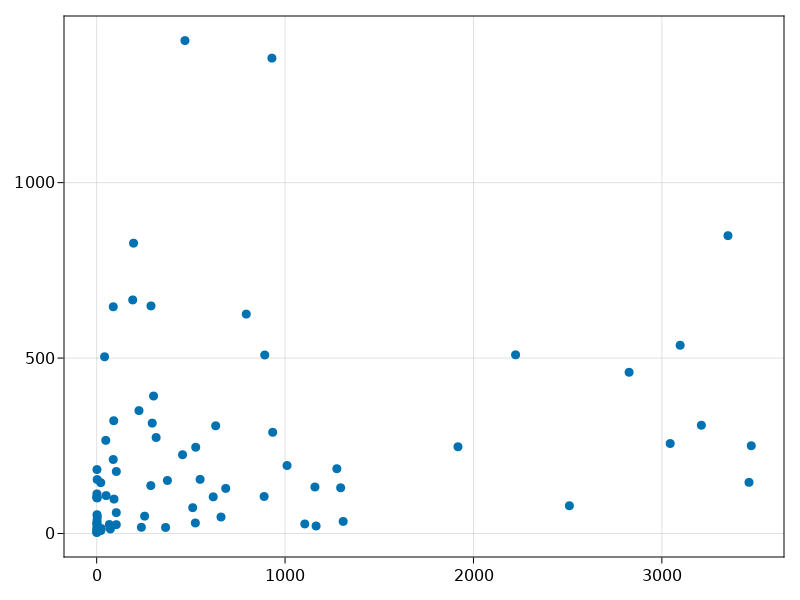

In [8]:
# Response variable vs predicted variable
scatter(y, yhat)

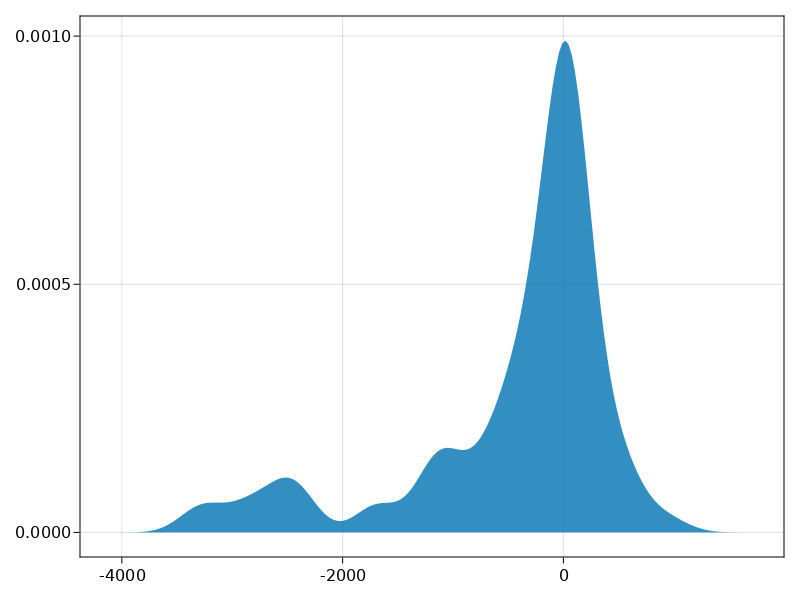

In [9]:
# Residuals density
density(yhat - y)